In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import sys
import os
from itertools import count
from datetime import datetime
import cProfile
from IPython.display import display, clear_output

import numpy as np
import torch
from matplotlib import pyplot as plt

sys.path.insert(0,'/home/brysongray/tractography/')
import tracking_interface
from env.sac_tracking_env import Environment
from agent.sac_tracker import SACModel

In [14]:
f = open('/home/brysongray/tractography/neuron_trx/configs/sac_config_8-9-24.json')
args = json.load(f)

img_dir = args["img_dir"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 100
gamma = args["gamma"] if "gamma" in args else 0.99
tau = args["tau"] if "tau" in args else 0.995
lr = args["lr"] if "lr" in args else 0.001
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17

env = Environment(img_dir,
                  radius=patch_radius,
                  seeds=seeds,
                  step_size=step_size,
                  step_width=step_width,
                  max_len=50,
                  alpha=alpha,
                  beta=beta,
                  friction=friction,
                  branching=False)

sac_model = SACModel(in_channels=4,
                     input_size=(2*patch_radius+1),
                     start_steps=1,
                     lr=lr,
                     gamma=gamma,
                     entropy_coeff=0.0,
                     n_filters=32)

# if model:
#     sac_model.load_model(model)

In [3]:
env.reset()
NOW = datetime.now().strftime("%m-%d-%Y_%H:%M:%S")

with cProfile.Profile() as pr:

    sac_model.train(env,
                episodes=10000,
                batch_size=batch_size,
                update_after=1,
                update_every=1,
                tau=tau,
                show=False,
                output='/home/brysongray/tractography/outputs_test',
                name=f'test_{NOW}'
                )
    
    pr.print_stats("cumtime")

  0%|          | 0/10000 [00:00<?, ?it/s]

Optimization begun


  0%|          | 6/10000 [10:37<295:05:33, 106.30s/it] 


KeyboardInterrupt: 

## view mask and density

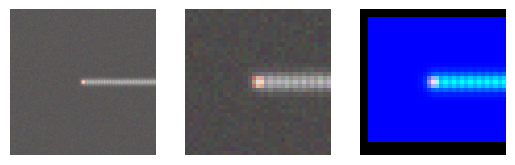

In [4]:
tracking_interface.show_state(env)

## Test crop  and draw_line_segment functions

In [ ]:
# c = env.paths[0][-1]
c = torch.tensor([50.0, 50.0, 50.0])
b = torch.tensor([0,0.0,0.0])
print(c+b)
r = 4
I = env.img.crop(center=c+b, radius=r, interp=True)[0][:3].cpu()
plt.figure()
plt.imshow(I[:, r].permute(1,2,0))

In [ ]:
env.reset()
c = env.paths[0][-1].cpu()
path_before = env.img.crop((c), r, interp=True)[0][3,r].cpu()
# create segment
theta = np.pi/2
v = torch.tensor([0.,-np.sin(theta),np.cos(theta)]) * env.step_size
segment = torch.stack(((c), (c+v))).to(device='cuda:0')
print(segment)
# draw segment
env.img.draw_line_segment(segment, width=env.step_width, channel=3, binary=True)
path_after = env.img.crop((c), r, interp=True)[0][3,r].cpu()

fig, ax = plt.subplots(1,2)
ax[0].imshow(path_before)
ax[1].imshow(path_after)

## Test draw_point function

In [ ]:
print(f'image shape: {env.img.data.shape}')
patch_radius = env.radius
patch ,_= env.img.crop(center=env.paths[0][-1], radius=patch_radius)
print(f'patch shape: {patch.shape}')

fig, ax = plt.subplots(1,3)
ax[0].imshow(patch[:3].cpu().amax(dim=1).permute(1,2,0))
ax[1].imshow(patch[3].cpu().amax(dim=0))
ax[2].imshow(patch[4].cpu().amax(dim=0))

In [ ]:
env.img.draw_point(env.paths[0][-1], radius=3, channel=4)
patch ,_= env.img.crop(center=env.paths[0][-1], radius=env.radius)
# test a boundary point
p = torch.tensor([50.0,0.0,50.0])
env.img.draw_point(p, radius=3, channel=4)
patch ,_= env.img.crop(p, radius=env.radius)
print(f'patch shape: {patch.shape}')

fig, ax = plt.subplots(1,3)
ax[0].imshow(patch[:3].cpu().amax(dim=1).permute(1,2,0))
ax[1].imshow(patch[3].cpu().amax(dim=0))
ax[2].imshow(patch[4].cpu().amax(dim=0))

## Test Reward Function

In [15]:
env.reset()

turn_around 
 reward: 0.0

reward: tensor([0.], device='cuda:0')
terminated: True


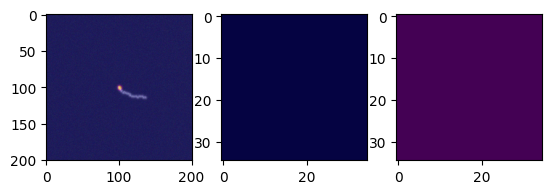

In [16]:
print(env.paths[env.head_id][-1])
tracking_interface.manual_step(env, step_size=2.0)

In [ ]:
bending_energy = []
bending_energy_ = []
segments_ = []
energy_ = []
for i in range(len(env.paths)):
    p0 = env.paths[i][:-1]
    p1 = env.paths[i][1:]
    segments = (p1 - p0) / env.step_size
    segments_.append(segments)
    energy = (torch.einsum('ij,ij->i', segments[1:], segments[:-1]) - 1.0) / -2.0
    energy_.append(energy)
    bending_energy_.append(torch.sum(energy))
bending_energy.append(torch.sum(torch.tensor(bending_energy_)))

In [ ]:
plt.close('all')

plt.ioff()
while True:
    dir = input()
    if dir == 'q':
        break
    clear_output(True)
    # observation, reward, terminated = env.step(dir_dict[dir], verbose=True)
    observation, reward, terminated = tracking_interface.manual_step(env, dir)

    print(reward)
    if not terminated:
        z = int(np.round(env.paths[env.head_id][-1,0]))
        plt.close()
        tracking_interface.show_state(env, z)
    else:
        env.reset()

In [ ]:
output='./outputs'
episodes = 128


# View results

In [ ]:
# name = "alpha-4.0_b-1.0_f-0.0_n-1"
# name = "alpha-1.0_b-0.3_f-0.0_n-1"
name = "test"
# output = "/home/brysongray/tractography/outputs_test_5-21-24_no_landmarks_n-2"
output = "/home/brysongray/tractography/outputs_test/" + name
returns = torch.load(os.path.join(output, f"episode_returns_{name}.pt"), weights_only=True)
durations = torch.load(os.path.join(output, f"episode_durations_{name}.pt"), weights_only=True)
n_paths = torch.load(os.path.join(output, f"n_paths_{name}.pt"), weights_only=True)
loss = torch.load(os.path.join(output, f"loss_{name}.pt"), weights_only=True)
matching_error = torch.load(os.path.join(output, f"matching_error_{name}.pt"), weights_only=True)
# eps = torch.load(os.path.join(output, f"eps_{name}.pt"))
# lr = torch.load(os.path.join(output, f"lr_{name}.pt"))

In [ ]:
len(matching_error)

In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].plot(torch.tensor(returns).cpu())
ax[1].plot(torch.tensor(durations).cpu())
ax[2].plot(torch.tensor(matching_error).cpu())
plt.show()

In [ ]:
plt.close('all')
fig, ax = plt.subplots(2,3)
for r in range(2):
    for c in range(3):
        i = r*3 + c

        # fname = f'/home/brysongray/tractography/outputs_test/bundle_density_ep{i-1}.pt'
        fname  = os.path.join(output, f"bundle_density_ep{i}.pt")
        density = torch.load(fname, weights_only=True)
        D = density.amax(dim=0).cpu()
        # D[np.where(D==0.0)] = np.nan
        # I = env.img.data[:3].amax(dim=(1))
        # T = env.true_density.data.amax(dim=(0,1)).cpu()
        # ax[r][c].imshow(I.permute(1,2,0), alpha=0.0)
        ax[r][c].imshow(D, cmap='hot', alpha=0.5, vmin=0.0, vmax=1.0)
        # ax[r][c].imshow(B, cmap='gray', alpha=0.5)
        # ax[r][c].imshow(T, cmap='gray', alpha=0.5)

# plt.imshow(T, cmap='gray', alpha=0.5)
plt.show()

# Inference

In [ ]:
f = open('/home/brysongray/tractography/neuron_trx/configs/sac_config_8-9-24.json')
args = json.load(f)

img_dir = args["img_dir"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 100
gamma = args["gamma"] if "gamma" in args else 0.99
tau = args["tau"] if "tau" in args else 0.995
lr = args["lr"] if "lr" in args else 0.001
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17

env = Environment(img_dir,
                  radius=patch_radius,
                  seeds=np.array([50,50,50]),
                  n_seeds=n_seeds,
                  step_size=step_size,
                  step_width=step_width,
                  alpha=alpha,
                  beta=beta,
                  friction=friction,
                  branching=True)

sac_model = SACModel(in_channels=5,
                    input_size=(2*patch_radius+1),
                    start_steps=50000,
                    lr=lr,
                    gamma=gamma,
                    entropy_coeff=0.2
                    )

params = torch.load("/home/brysongray/tractography/outputs_test/test/model_state_dicts_test.pt", weights_only=True)

sac_model.load_model(params["policy_state_dict"], params["Q1_state_dict"], params["Q2_state_dict"])


In [ ]:
count = 0
for nn in params.values():
    for key in nn:
        count += nn[key].numel()
print(count)

In [ ]:
env.reset()

In [ ]:
I = []
B = []
T = []
for s in range(len(env.seeds)):
    env = sac_model.inference(env, out="/home/brysongray/tractography/outputs_test/inference")
    I.append(np.array(env.img.data[:3].to('cpu')))
    T.append(np.array(env.true_density.data.to('cpu')))
    B.append(np.array(env.img.data[3].to('cpu')))

In [ ]:
B[0].shape

In [ ]:
fig, ax = plt.subplots(2,3)
I_ = I[0].transpose(1,2,3,0)
T_ = T[0][0]
B_ = B[0]
ax[0,0].imshow(I_.max(0))
ax[0,1].imshow(I_.max(1))
ax[0,2].imshow(I_.max(2))
ax[1,0].imshow(T_.max(0))
ax[1,1].imshow(T_.max(1))
ax[1,2].imshow(T_.max(2))
ax[1,0].imshow(B_.max(0), alpha=0.5)
ax[1,1].imshow(B_.max(1), alpha=0.5)
ax[1,2].imshow(B_.max(2), alpha=0.5)
plt.show()

In [ ]:
z=23
fig, ax = plt.subplots(2,3)
for i in range(6):
    Ii = I[i][:,z] #.max(axis=1)
    # Ti = T[i][0].max(axis=0)
    # Bi = B[i][0].max(axis=0)
    j = i//3
    k = i%3
    ax[j][k].imshow(Ii[-1], cmap='hot', alpha=0.5) #, int(paths[env.head_id][-1, 0])])
    ax[j][k].imshow(Ii[:3].transpose(1,2,0), alpha=0.5)
    # ax[j][k].imshow(Bi, cmap='hot', alpha=0.5)
    # ax[j][k].imshow(Ti, cmap='gray', alpha=0.5)
    plt.show()


## Compare models

In [ ]:
dir = "/home/brysongray/tractography/outputs"
outputs = os.listdir(dir)

returns_files = [o for o in outputs if "returns" in o]
durations_files = [o for o in outputs if "durations" in o]
mae_files = [o for o in outputs if "matching" in o]
friction_files = [o for o in outputs if "friction" in o]
bending_energy_files = [o for o in outputs if "bending_energy" in o]
bending_energy_files.sort()
friction_files.sort()
mae_files.sort()
returns_files.sort()
durations_files.sort()

returns = []
durations = []
maes = []
frictions = []
bending_energies = []
for i in range(len(returns_files)):
    returns.append(torch.tensor(torch.load(os.path.join(dir,returns_files[i]))))
    durations.append(torch.tensor(torch.load(os.path.join(dir,durations_files[i]))))
    maes.append(torch.tensor(torch.load(os.path.join(dir, mae_files[i]))))
    frictions.append(torch.tensor(torch.load(os.path.join(dir, friction_files[i]))))
    bending_energies.append(torch.tensor(torch.load(os.path.join(dir, bending_energy_files[i]))))


In [ ]:
Z = np.zeros(len(maes))
for i,m in enumerate(maes):
    Z[i]= m.min().item()



In [ ]:
print(np.argmin(Z))
print(returns_files[np.argmin(Z)])
print(min(Z))

In [ ]:
i = np.argmin(Z)
ep_returns = returns[i]
ep_durations = durations[i]
mae = maes[i]
friction = frictions[i]
bending_energy = bending_energies[i]

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].plot(ep_returns.numpy())
ax[1].plot(ep_durations.numpy())

In [ ]:
friction.shape

In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].plot(mae)
ax[1].plot(bending_energy / friction)
ax[2].plot(friction)